Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print('Extracting data for %s. This may take a while. Please wait.' % root)
  sys.stdout.flush()
  tar.extractall()
  tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    image_index = 0
    print folder
    for image in os.listdir(folder):
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) - 
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % 
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def load(data_folders, min_num_images_per_class):
  dataset_names = []
  for folder in data_folders:
    dataset = load_letter(folder, min_num_images_per_class)
    set_filename = folder + '.pickle'
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        dataset_names.append(set_filename)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
  
  return dataset_names

train_datasets = load(train_folders, 45000)
test_datasets = load(test_folders, 1800)

notMNIST_large/A
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError("cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'",), "- it's ok, skipping.")
('Full dataset tensor:', (52909, 28, 28))
('Mean:', -0.12825024)
('Standard deviation:', 0.44312063)
notMNIST_large/B
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'",), "- it's ok, skipping.")
('Full dataset tensor:', (52911, 28, 28))
('Mean:', -0.00

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

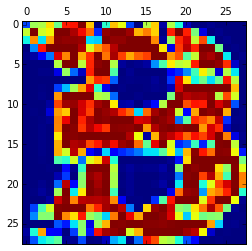

In [82]:
plt.matshow (pickle.load( open(train_datasets[1], "rb" ) )[10])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
          print('Unable to process data from', pickle_file, ':', e)
          raise
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
__, __, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [7]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [8]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 690800441)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  cleaned_valid_dataset = save['cleaned_valid_dataset']
  cleaned_valid_labels = save['cleaned_valid_labels']
  cleaned_test_dataset = save['cleaned_test_dataset']
  cleaned_test_labels = save['cleaned_test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (10000, 28, 28), (10000,))


In [3]:
def binary_search(alist, item):
    'Return a list of indices that matches item. alist need to be a sorted numpy array.'
    indices = []
    idx = np.searchsorted(alist, item)
    while idx < len(alist) and alist[idx] == item:
        indices.append(idx)
        idx += 1
    return indices

In [18]:
ind = np.lexsort([train_dataset[:,i,j] 
                  for i in range(train_dataset.shape[1]-1,-1,-1) 
                  for j in range(train_dataset.shape[2]-1,-1,-1)])  
sorted_train_dataset = train_dataset[ind]

In [29]:
def search_training(sorted_arr, item, i=0, j=0):
    found = False
    idx = binary_search(sorted_arr[:,i,j], item[i,j])
    if idx:
        if j == sorted_arr.shape[2]-1:
            if i == sorted_arr.shape[1]-1:
                return True
            else:
                i += 1
                j = 0
        else:
            j += 1
        data = sorted_arr[idx]            
        found = search_training(data, item, i, j)
    return found

In [117]:
# Take hours!
valid_ovlp = []
for ii, item in enumerate(valid_dataset):
    if search_training(sorted_train_dataset, item):
        valid_ovlp.append(ii)

In [54]:
print len(valid_ovlp), ' data points in validation set appear in training set as well.'

190  data points in validation set appear in training set as well.


In [67]:
cleaned_valid_dataset = np.delete(valid_dataset, np.array(valid_ovlp), axis=0)
cleaned_valid_labels = np.delete(valid_labels, np.array(valid_ovlp), axis=0)

In [119]:
# Take hours!
test_ovlp = []
for ii, item in enumerate(test_dataset):
    if search_training(sorted_train_dataset, item):
        test_ovlp.append(ii)

In [127]:
print len(test_ovlp), ' data points in test set appear in training set as well.'

2291  data points in test set appear in training set as well.


In [131]:
cleaned_test_dataset = np.delete(test_dataset, np.array(test_ovlp), axis=0)
cleaned_test_labels = np.delete(test_labels, np.array(test_ovlp), axis=0)

In [132]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'cleaned_valid_dataset': cleaned_valid_dataset,
    'cleaned_valid_labels': cleaned_valid_labels,
    'cleaned_test_dataset': cleaned_test_dataset,
    'cleaned_test_labels': cleaned_test_labels    
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [8]:
train_size = [50, 100, 1000, 5000]
for size in train_size:
    training_data_samples = train_dataset[:size]
    training_data_samples = training_data_samples.reshape((-1, image_size * image_size)).astype(np.float32)
    training_label_samples = train_labels[:size]

    logistic = LogisticRegression()
    logistic.fit(training_data_samples, training_label_samples)
    print 'Training size = {}. Accuracy on test set is {}. Accuracy on cleaned test set is {}.'.format(size, 
        logistic.score(test_dataset.reshape((-1, image_size * image_size)).astype(np.float32), test_labels),
        logistic.score(cleaned_test_dataset.reshape((-1, image_size * image_size)).astype(np.float32), 
                       cleaned_test_labels))

Training size = 50. Accuracy on test set is 0.592. Accuracy on cleaned test set is 0.569853418083.
Training size = 100. Accuracy on test set is 0.7525. Accuracy on cleaned test set is 0.723569853418.
Training size = 1000. Accuracy on test set is 0.8301. Accuracy on cleaned test set is 0.80347645609.
Training size = 5000. Accuracy on test set is 0.8538. Accuracy on cleaned test set is 0.826177195486.


In [ ]:
training_data_samples = train_dataset.reshape((-1, image_size * image_size)).astype(np.float32)
training_label_samples = train_labels

logistic = LogisticRegression()
logistic.fit(training_data_samples, training_label_samples)
print 'Accuracy on test set is {}. Accuracy on cleaned test set is {}.'.format(
    logistic.score(test_dataset.reshape((-1, image_size * image_size)).astype(np.float32), test_labels),
    logistic.score(cleaned_test_dataset.reshape((-1, image_size * image_size)).astype(np.float32), 
                       cleaned_test_labels))